In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

C:\Users\BarkY\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Found cached dataset subjqa (C:/Users/BarkY/.cache/huggingface/datasets/subjqa/electronics/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6)
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 105.00it/s]


In [3]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [4]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [5]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [6]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

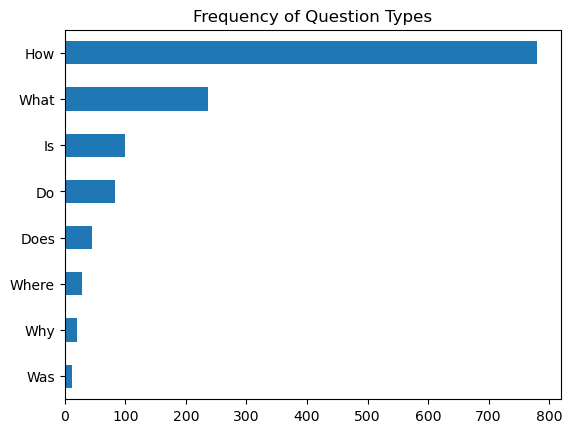

In [7]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [8]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
            .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Tokenizing text for QA

In [9]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [10]:
question = "How much music can this hold?"

context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [11]:
tokenizer.decode(inputs["input_ids"][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]'

In [12]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [13]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


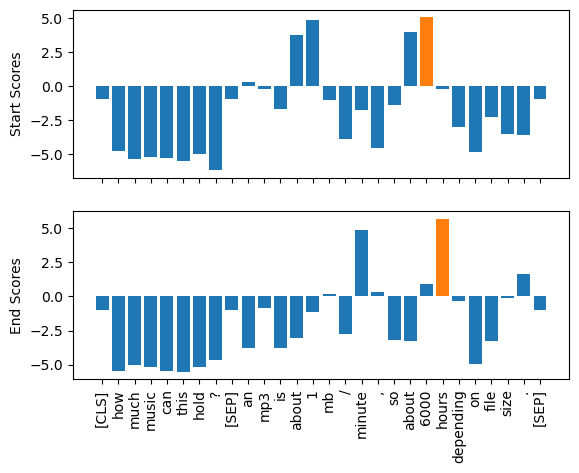

In [14]:
import numpy as np

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

In [15]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [16]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

C:\Users\BarkY\anaconda3\envs\pytorch-env\lib\site-packages\transformers\pipelines\question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651625871658325, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082915902137756,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253461450338364,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [17]:
# question with no anwser possible, assign high start and end score to the [CLS] token
pipe(question="Why is there no data?", context=context,
handle_impossible_answer=True)

{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''}

In [18]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], truncation=True, return_overflowing_tokens=True, max_length=100, stride=25)

for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [19]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



## Using Haystack to Build a QA Pipeline

Linux
import os
from subprocess import Popen, PIPE, STDOUT
Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
stdout=PIPE, stderr=STDOUT)
Wait until Elasticsearch has started
!sleep 30

In [20]:
!curl -X GET "localhost:9200/?pretty"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   540  100   540    0     0  10033      0 --:--:-- --:--:-- --:--:-- 10188


{
  "name" : "DESKTOP-4PKJAL7",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "EinT3Mr3RLubjO2rJ3sVYw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "zip",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [21]:
from haystack.document_stores import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

INFO - haystack.document_stores.base -  Numba not found, replacing njit() with no-op implementation. Enable it with 'pip install numba'.
INFO - haystack.modeling.model.optimization -  apex not found, won't use it. See https://nvidia.github.io/apex/
ERROR - root -  Failed to import 'magic' (from 'python-magic' and 'python-magic-bin' on Windows). FileTypeClassifier will not perform mimetype detection on extensionless files. Please make sure the necessary OS libraries are installed if you need this functionality.


In [22]:
dfs["train"].iloc[0]

domain                                                                                           electronics
nn_mod                                                                                                 great
nn_asp                                                                                         bass response
query_mod                                                                                          excellent
query_asp                                                                                               bass
q_reviews_id                                                                0514ee34b672623dff659334a25b599b
question_subj_level                                                                                        5
ques_subj_score                                                                                          0.5
is_ques_subjective                                                                                     False
review_id          

In [23]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"],
             "meta": {"item_id": row["title"], "question_id": row["id"], "split": split}}
           for _, row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


## Initializing a retriever

In [24]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

WARNING - haystack.retriever.sparse -  This class is now deprecated. Please use the BM25Retriever instead


In [25]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [26]:
print(retrieved_docs[0])

<Document: id=252e83e25d52df7311d597dc89eef9f6, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never  ...'>


In [27]:
print(retrieved_docs[0].content)

This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.


## Initializing a reader

In [28]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/minilm-uncased-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/minilm-uncased-squad2
INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.infer -  Got ya 31 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0  
INFO - haystack.modeling.infer -  /w\   /w\   /w\   /w\   /w\

In [29]:
reader.predict_on_texts(question=question, texts=[context], top_k=1)

C:\Users\BarkY\anaconda3\envs\pytorch-env\lib\site-packages\haystack\modeling\model\prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len


{'query': 'How much music can this hold?',
 'no_ans_gap': 12.648075580596924,
 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293045192956924, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id': 'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}

## Putting it all together

In [30]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

WARNING - haystack -  Object 'ExtractiveQAPipeline' is imported through a deprecated path. Please check out the docs for the new import path.


In [31]:
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"item_id": [item_id], "split":["train"]}}, 
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





## Improving our QA Pipeline

## Evaluating the Retriever

In [32]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=es_retriever)

In [33]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]}
            )
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
                query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=True, filters={"item_id": [row["title"]], "split":["test"]}
        )  
        labels.append(label)

In [34]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 910 question-answer pairs


In [35]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [36]:
print(labels_agg[109])

<MultiLabel: {'labels': [{'id': 'bcb868c8-b74d-4701-957f-3533dd098b43', 'query': 'How does the fan work?', 'document': {'content': 'In most demanding games, my GPU will consistently soar to 90-93 degrees Celsius. I didn\'t like seeing temps in the 90s so I figured I would pick up this Cooler Master for a shade over $20. Is it worth it? I think it is.My Sager NP8130 is 15.6" and this cooler fits it just about perfectly - I have maybe 1" of extra room. My laptop\'s rubber stops on the bottom keep it anchored pretty well, and the fan itself isn\'t super loud. There is an adjustable dial to change fan speed, but when I\'m gaming, I generally just have it on max, and when I\'m not gaming, I turn the cooling pad off altogether.The one thing I would make sure you do is use the little legs on the bottom of the cooling pad to prop it up an extra half inch or so. It makes a world of difference in how much more air can flow through under the pad and up to your laptop. Also, beware of using this o

In [37]:
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.95


In [38]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "content", "gold_document_contents", "document_id", "gold_document_ids", "gold_id_match"]]

,query,filters,rank,content,gold_document_contents,document_id,gold_document_ids,gold_id_match
0,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,I bought this lens for my Canon 20D digital camera and have found it to be a...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,3566c491f5aafe80a22667754727dfc0,[fac2e8bec06035a70307dd1e8034ea63],0.0
1,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,I am not a professional or expert photographer...so take these comments with...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,d5c7736727a38c2fe62df10beef4a5ce,[fac2e8bec06035a70307dd1e8034ea63],0.0
0,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,I think that the title says it all. It is one of the cheapest lens on the ma...,[],ebfb4b46819be7c051b27f0c28efd0fb,[],0.0
1,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,I bough this lens for a relative who bought my old canon rebel xti from me (...,[],94163306f4c5c35c83ed165b2282cd32,[],0.0
2,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,"I fell in love with the lens the moment I started using it. sure, the build ...",[],7f5d77178fe93006124f731249d245f8,[],0.0
0,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,"I have read a lot of negative press about this lens, but I have to tell you ...","[I have read a lot of negative press about this lens, but I have to tell you...",11818a689fbac56cbb063eb658b22c05,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62cf296d394d993741d660aa]",0.0


In [39]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    for topk in topk_values:
        # Create Pipeline
        p = DocumentSearchPipeline(retriever=retriever)
        # Loop over each question-answers pair in test set
        eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": topk}},
        )
        metrics = eval_result.calculate_metrics()
        # Get metrics
        topk_results[topk] = {"recall": metrics['Retriever']['recall_single_hit']}
    return pd.DataFrame.from_dict(topk_results, orient="index")
es_topk_df = evaluate_retriever(es_retriever)

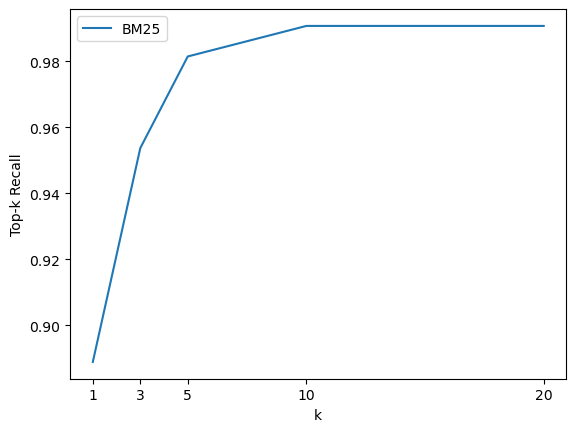

In [40]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([es_topk_df], ["BM25"])


## Dense Passage Retrieval

In [41]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find facebook/dpr-question_encoder-single-nq-base locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded facebook/dpr-question_encoder-single-nq-base
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  ======

In [42]:
document_store.update_embeddings(retriever=dpr_retriever)

INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 1615 docs ...
Create embeddings: 100%|████████████████████████████████████████████████████████| 1616/1616 [05:51<00:00,  4.69 Docs/s]
Updating embeddings: 10000 Docs [05:57, 27.98 Docs/s]                                                                  


In [43]:
dpr_topk_df = evaluate_retriever(dpr_retriever)

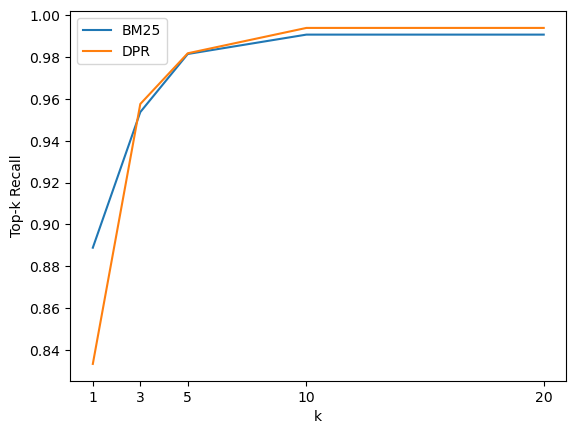

In [44]:
plot_retriever_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

## Evaluating the Reader

In [45]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [46]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [ ]:
from haystack.pipelines import Pipeline

def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])
    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

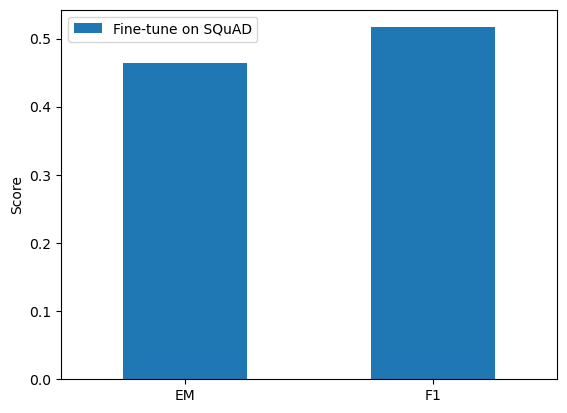

In [48]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

# the fine-tuned model performs significantly worse on SubjQA than on SQuAD 2.0

## Domain Adaptation

In [50]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append(
                {"question": question, "id": qid, "is_impossible": is_impossible, "answers": answers}
            )
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [56]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create paragraphs for each product
        groups = (df.groupby("title").apply(create_paragraphs).to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)

convert_to_squad(dfs)

In [57]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.data_handler.data_silo -  
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO - haystack.modeling.data_handler.data_silo -  LOADING TRAIN DATA
INFO - haystack.modeling.data_handler.data_silo -  ==================
INFO - haystack.modeling.data_handler.data_silo -  Loading train set from: electronics-train.json 
INFO - haystack.modeling.data_handler.data_silo -  Got ya 31 parallel workers to convert 1265 dictionaries to pytorch datasets (chunksize = 9)...
INFO - haystack.modeling.data_handler.data_silo -   0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0  
INFO - haystack.modeling.data_handler.data

In [ ]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)

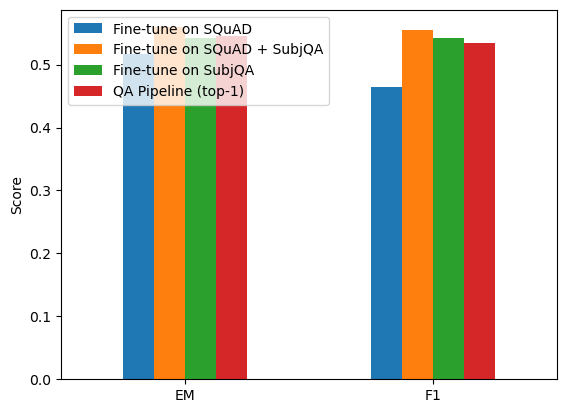

In [64]:
plot_reader_eval(reader_eval)

In [59]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find microsoft/MiniLM-L12-H384-uncased locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
Downloading: 100%|█████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 257kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 127M/127M [00:18<00:00, 7.20MB/s]
INFO - haystack.modeling.model.language_model -  Loaded microsoft/MiniLM-L12-H384-uncased
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN

In [60]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
                    train_filename=train_filename, dev_filename=dev_filename)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.data_handler.data_silo -  
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO - haystack.modeling.data_handler.data_silo -  LOADING TRAIN DATA
INFO - haystack.modeling.data_handler.data_silo -  ==================
INFO - haystack.modeling.data_handler.data_silo -  Loading train set from: electronics-train.json 
INFO - haystack.modeling.data_handler.data_silo -  Got ya 31 parallel workers to convert 1265 dictionaries to pytorch datasets (chunksize = 9)...
INFO - haystack.modeling.data_handler.data_silo -   0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0  
INFO - haystack.modeling.data_handler.data

In [ ]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

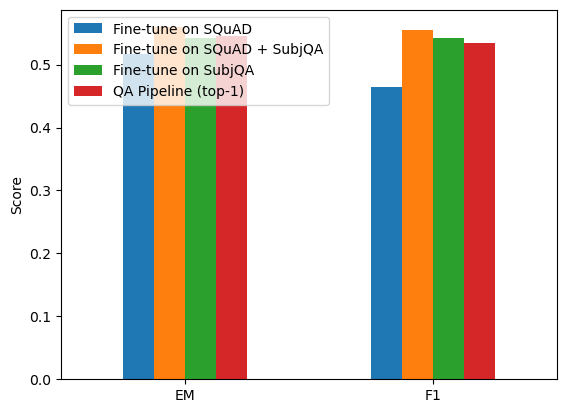

In [70]:
plot_reader_eval(reader_eval)

# Evaluating the Whole QA Pipeline

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=es_retriever, reader=reader)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

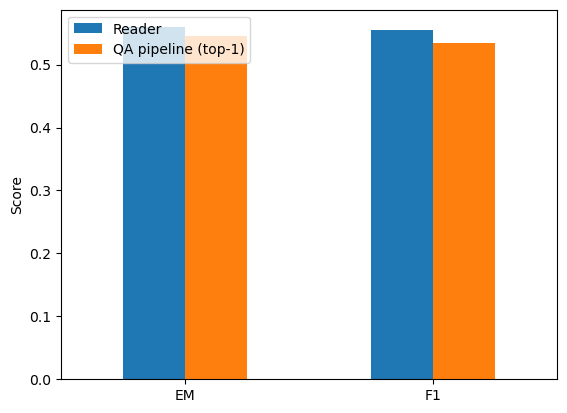

In [63]:
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

## Going Beyond Extractive QA
### Retrieval-Augmented Generation

In [65]:
from haystack.nodes import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
Downloading: 100%|████████████████████████████████████████████████████████████████| 4.49k/4.49k [00:00<00:00, 9.21MB/s]
C:\Users\BarkY\anaconda3\envs\pytorch-env\lib\site-packages\transformers\models\bart\configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
Downloading: 100%|██████████████████████████████████████████████████████████████████| 226k/226k [00:00<00:00, 1.06MB/s]
Downloading: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 112kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 48.0/48.0 [00:00<00:00, 48.0kB/s]
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result i

In [66]:
from haystack.pipelines import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [67]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query, 
                     params={"Retriever": {"top_k":5, 
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})  
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx].answer}")

In [68]:
generate_answers(query)

C:\Users\BarkY\anaconda3\envs\pytorch-env\lib\site-packages\transformers\models\rag\tokenization_rag.py:92: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(
C:\Users\BarkY\anaconda3\envs\pytorch-env\lib\site-packages\transformers\generation_utils.py:1747: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


Question: Is it good for reading? 

Answer 1:  the screen is absolutely beautiful
Answer 2:  the Screen is absolutely beautiful
Answer 3:  Kindle fire


In [69]:
generate_answers("What is the main drawback?")

Question: What is the main drawback? 

Answer 1:  the price
Answer 2:  no flash support
Answer 3:  the cost
